本文是本课程的归纳整理，集大成者。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from pandas.plotting import autocorrelation_plot

# 公共函数

In [94]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time    

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def split(time, series, split_time=1000):
    time_train = time[:split_time]
    x_train = series[:split_time]
    time_valid = time[split_time:]
    x_valid = series[split_time:]  
    return time_train, x_train, time_valid, x_valid

def update_result(df_results, data_name, model_name, x, forecast):
    mse = round(tf.keras.metrics.mean_squared_error(x, forecast).numpy(), 4)
    mae = round(tf.keras.metrics.mean_absolute_error(x, forecast).numpy(), 4)
    df_results = df_results.append({'data_name':data_name, 'model_name':model_name, 'mse':mse , 'mae':mae}, ignore_index=True)
    return df_results

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# display(HTML("<style>.container { width:1300px !important; }</style>"))
# display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

# 时间序列数据

时间序列数据往往呈现出以下特性：

- 趋势 Trend
- 季节性 Seasonality
- 噪音 Noise
- 自相关 Autocorrelation

实际的数据，往往是以上特性的混合。下面通过人为的方法来生成这些特性，然后进行混合，这样可以加深对时间序列数据的理解。

## 趋势 Trend

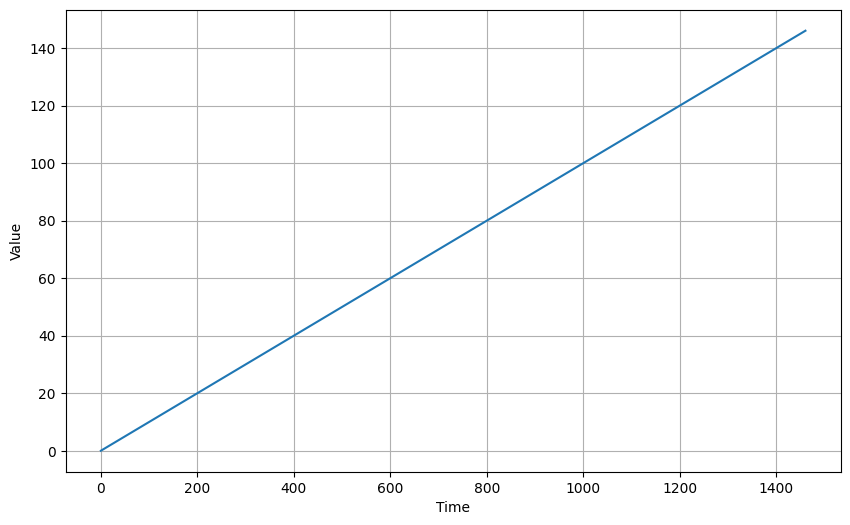

In [4]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## 季节性 Seasonality

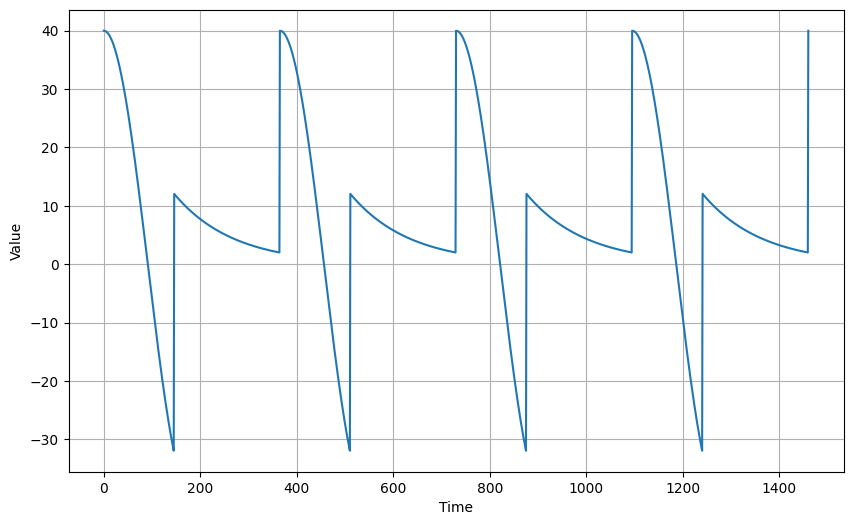

In [5]:
time = np.arange(4 * 365 + 1)
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## 趋势 + 季节性

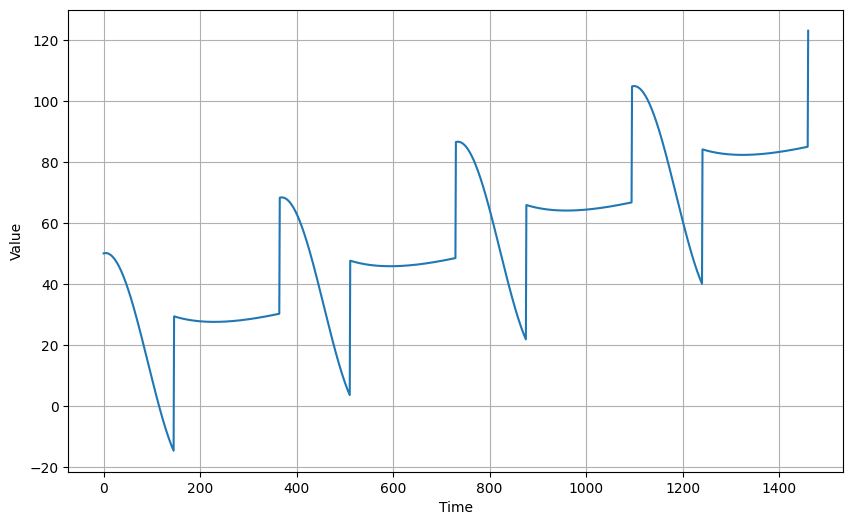

In [6]:
time = np.arange(4 * 365 + 1)
slope = 0.05
baseline = 10
amplitude = 40

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## 噪音 Noise

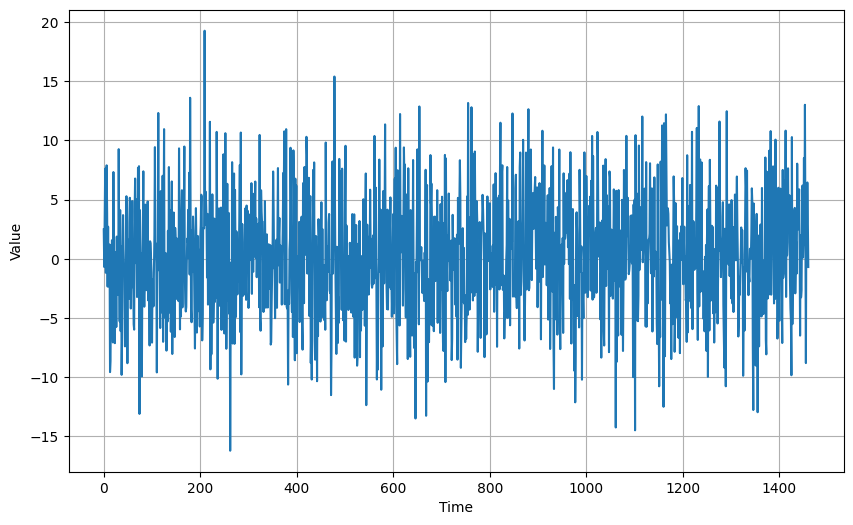

In [7]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

## 趋势 + 季节性  + 噪音

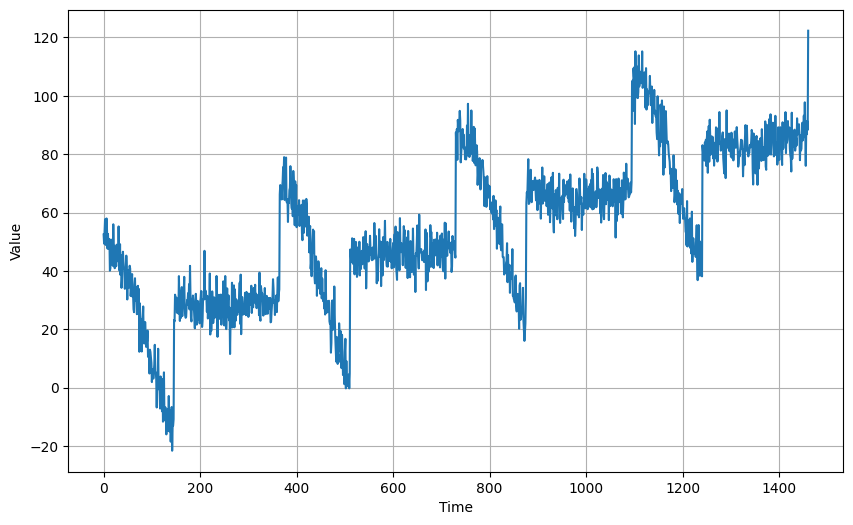

In [8]:
time = np.arange(4 * 365 + 1)
slope = 0.05
baseline = 10
amplitude = 40
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## 自相关 Autocorrelation 

### 第一个自相关函数

$$
s(t) = rnd() + \phi1 \times s[t - 50] + \phi2 \times s[t - 33]
$$


In [9]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

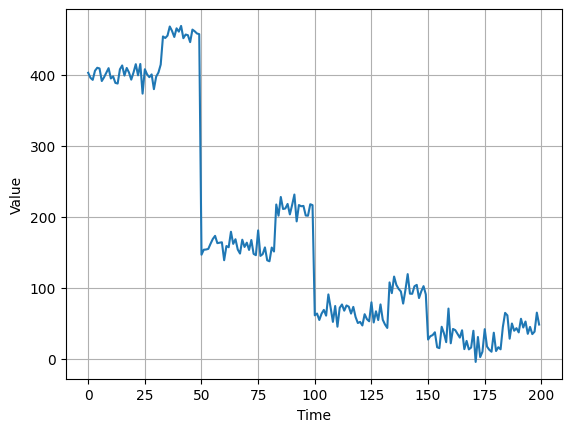

In [10]:
time = np.arange(4 * 365 + 1)

series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

#### 自相关 + 趋势

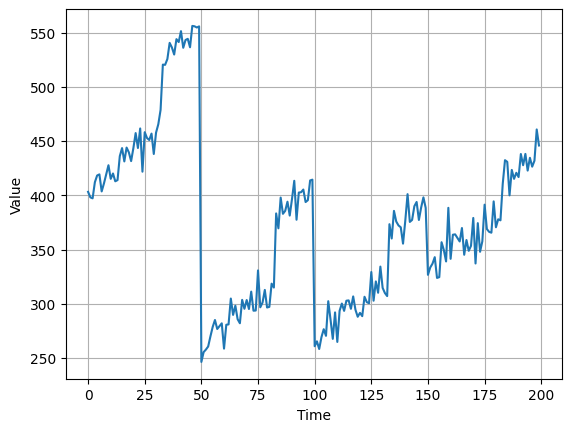

In [11]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

#### 自相关 + 趋势 + 季节性

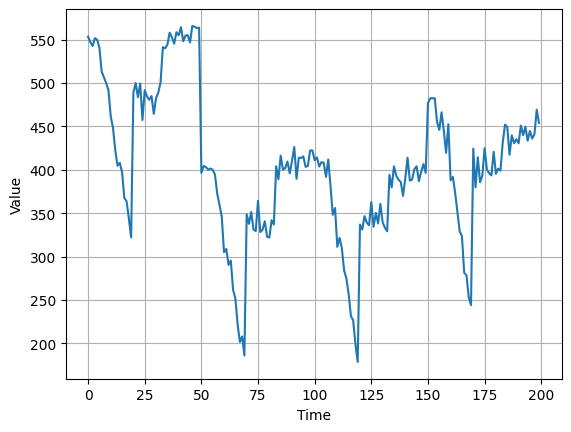

In [12]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

#### 深度混合： 不同自相关 + 不同季节性

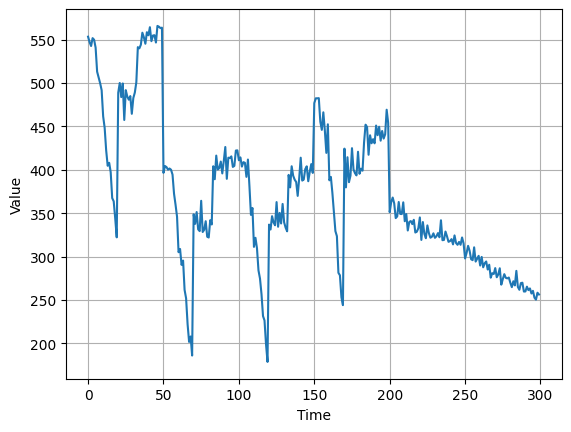

In [13]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]

plot_series(time[:300], series[:300])
plt.show()

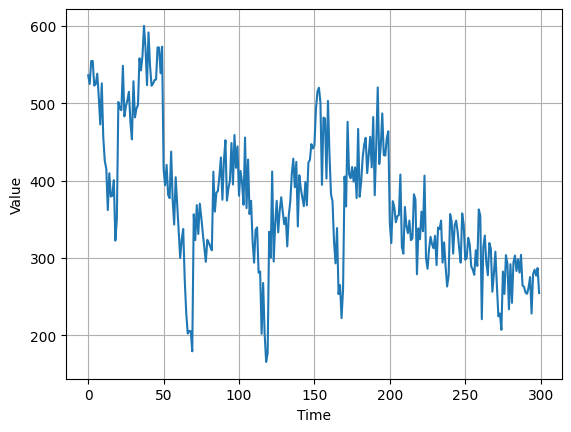

In [14]:
series += white_noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

### 第二个自相关函数

比起第一个自相关函数要更加简单一些。

$$
s(t) = rnd() + \phi \times s[t - 1] 
$$

In [15]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

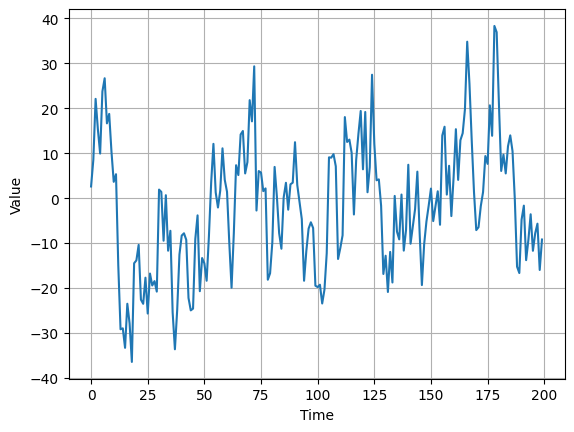

In [16]:
time = np.arange(4 * 365 + 1)

series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

#### 自相关 + 趋势

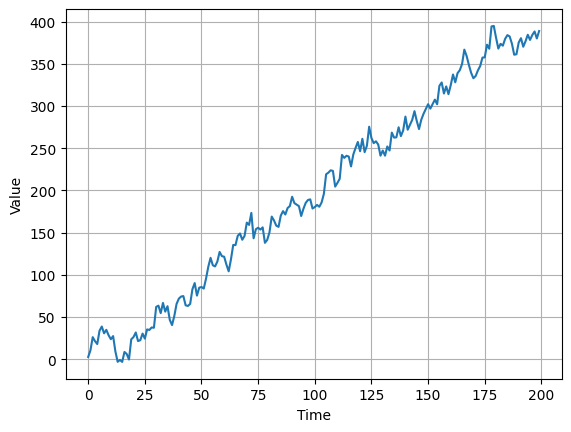

In [17]:
series = autocorrelation(time, 10, seed=42) +  trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

#### 自相关 + 趋势 + 季节性

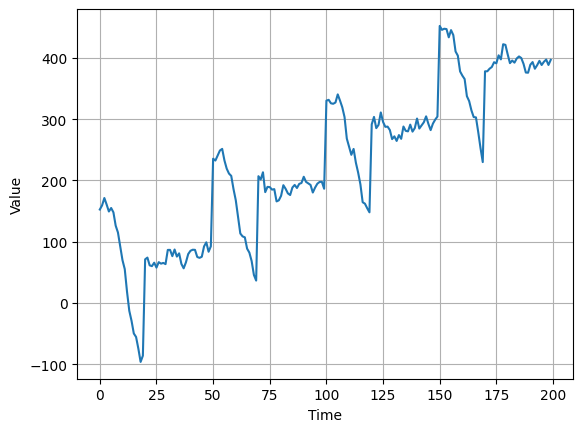

In [18]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

#### 深度混合： 不同自相关 + 不同季节性

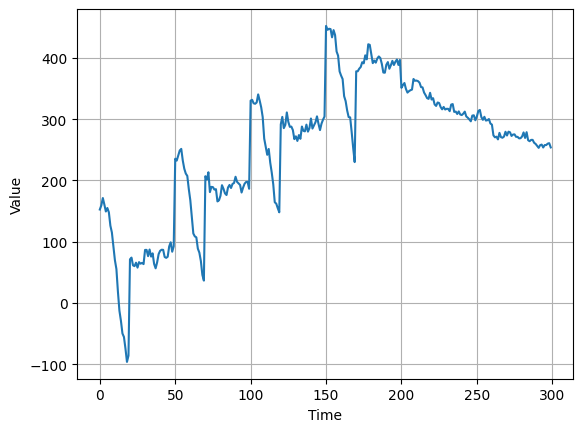

In [19]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]

plot_series(time[:300], series[:300])
plt.show()

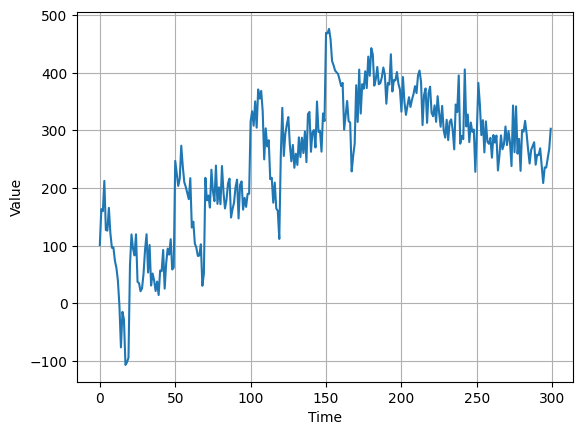

In [20]:
series += white_noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

### 第三个自相关函数

脉冲函数，在若干个点，瞬间出现变化。

In [21]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series   

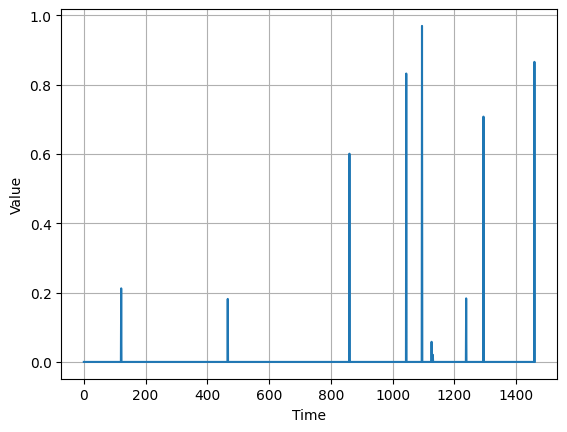

In [22]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

#### 脉冲信号 + 自相关函数

In [23]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
                ar[step] += φ * ar[step - lag]
    return ar

##### 一个自相关性系数

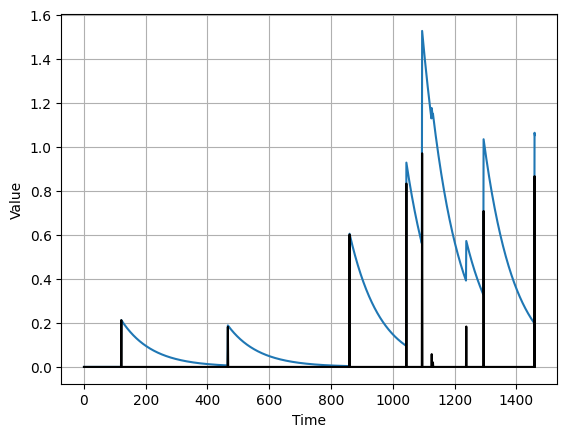

In [24]:
time = np.arange(4 * 365 + 1)
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})


plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

##### 两个自相关系数。

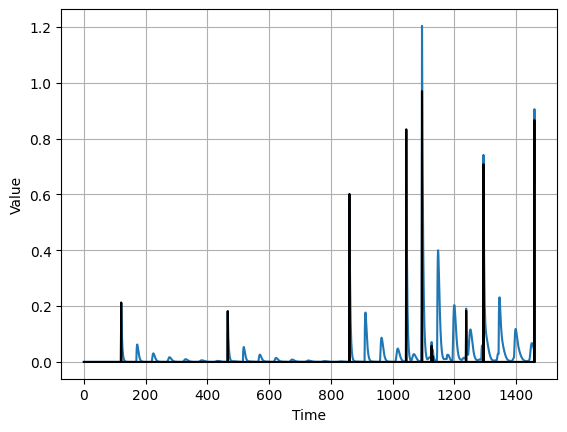

In [25]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

# 经典时间序列分析

根据前文所述，时间序列往往是以下几个因素的多个的混合。

- 趋势 Trend
- 季节性 Seasonality
- 噪音 Noise
- 自相关 Autocorrelation

本节将尝试多种方法来分析。

## 一阶差分

使用差分能够消除一定的趋势性。

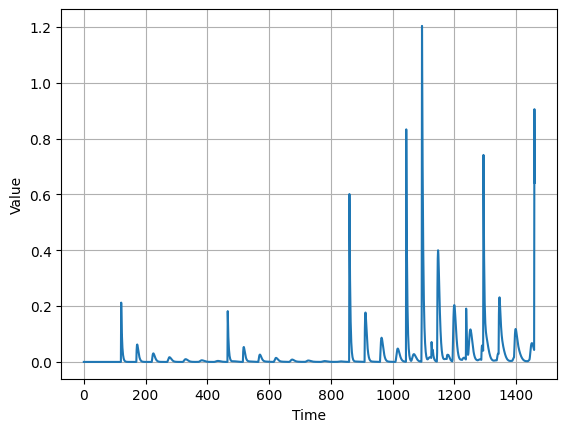

In [26]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
                ar[step] += φ * ar[step - lag]
    return ar

time = np.arange(4 * 365 + 1)

signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})

plot_series(time, series)
plt.show()

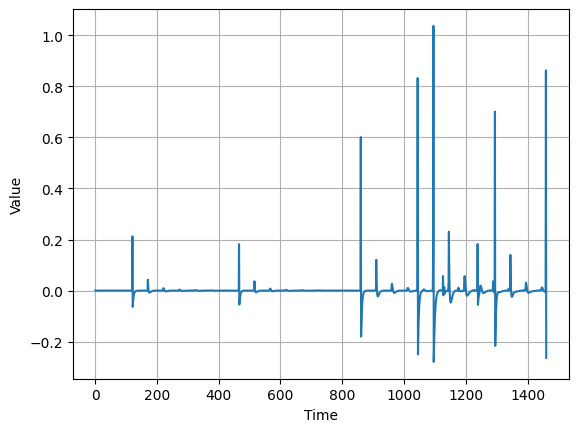

In [27]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)
plt.show()

也可以用Padas的Series来实现相同效果`m

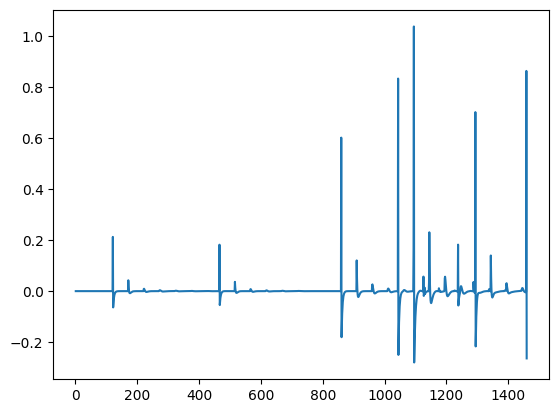

In [28]:
pd_series = pd.Series(series)
pd_series.diff(1).plot()
plt.show()

## 自相关系数

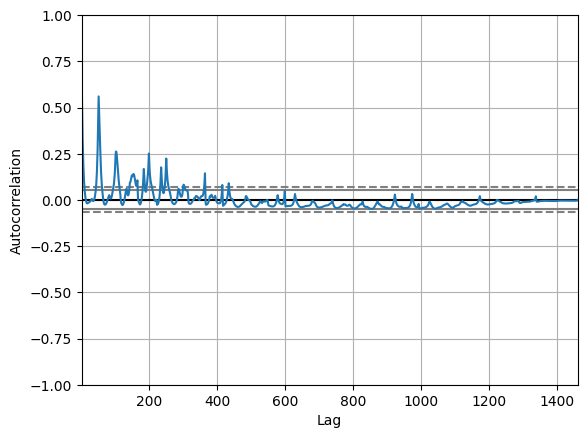

In [29]:
autocorrelation_plot(series)
plt.show()

上图可以相邻数据的相关性是比较高的。

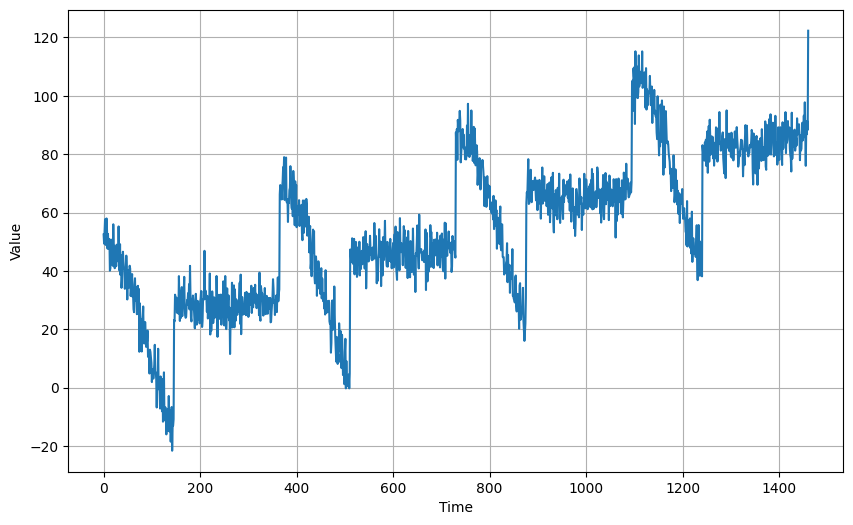

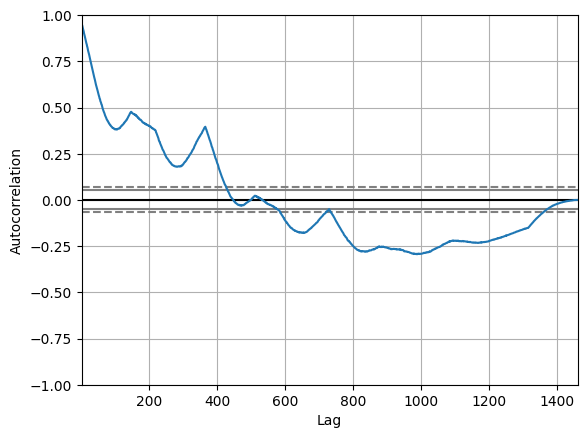

In [30]:
time = np.arange(4 * 365 + 1)
slope = 0.05
baseline = 10
amplitude = 40
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

autocorrelation_plot(series)
plt.show()

## 使用ARIMA

In [31]:
import statsmodels.api as sm 

model = sm.tsa.arima.ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary()) 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1461
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4814.865
Date:                Thu, 20 Jan 2022   AIC                           9641.730
Time:                        07:37:03   BIC                           9673.447
Sample:                             0   HQIC                          9653.561
                               - 1461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5783      0.016    -35.575      0.000      -0.610      -0.546
ar.L2         -0.3085      0.023    -13.349      0.000      -0.354      -0.263
ar.L3         -0.1129      0.029     -3.828      0.0

# 经典时间序列预测

下面通过一个人造数据的预测，看看经典的时间序列预测的效果如何。

## 创建数据： trend + seasonality + noise

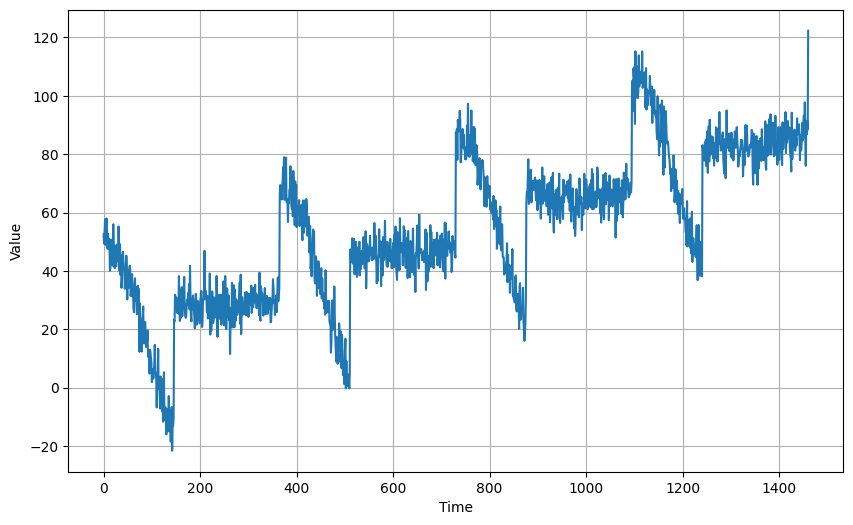

In [32]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [33]:
# 数据拆分为训练集和验证集
split_time = 1000
time_train, x_train, time_valid, x_valid = split(time, series, split_time=split_time)

## 模型

首先初始化模型结果，便于后面的比较。

In [97]:
df_results = pd.DataFrame(columns=['data_name', 'model_name', 'mse', 'mae'])

### 朴素预测 Naive Forecast
最简单的预测就是采用前一天的值来预测。

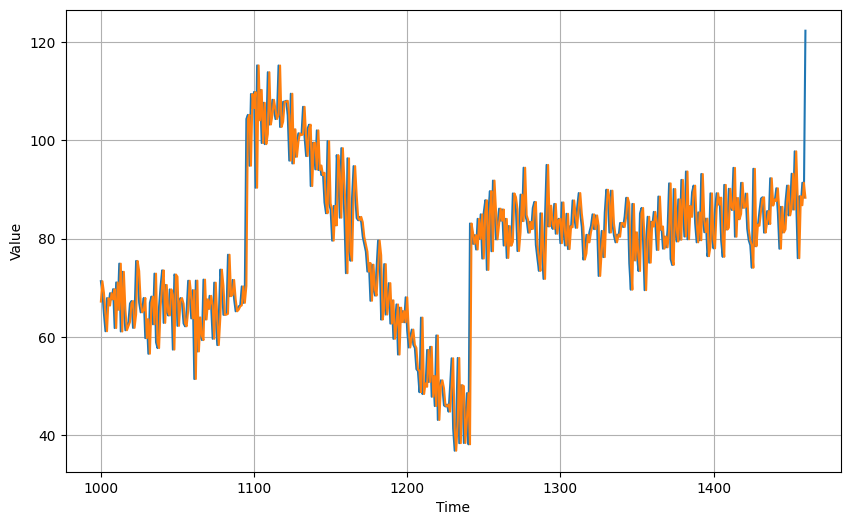

In [34]:
naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
plt.show()

可以看到实际和预测重合度非常高，这是人类对于时间序列的本能预测，其实效果还不错。下面放大一下局部看看。

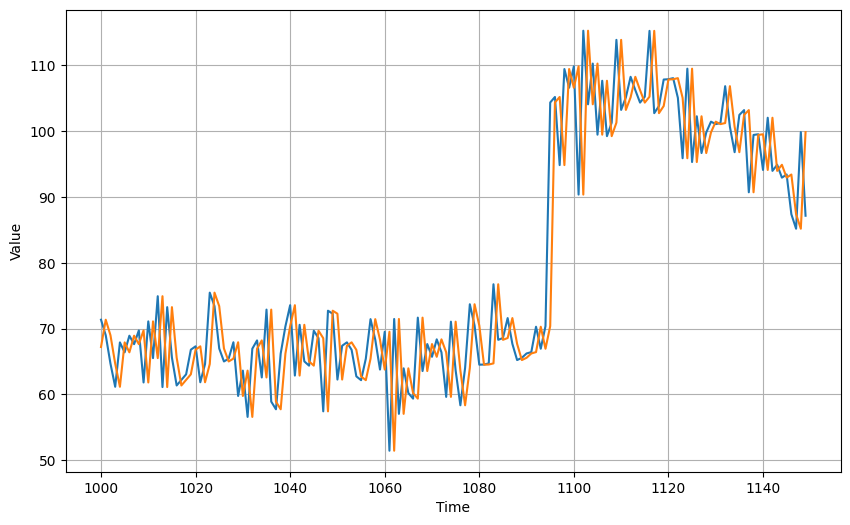

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=0, end=150)

plt.show()

In [98]:
data_name = 'custom_data1'
model_name = 'native_forecast'
df_results = update_result(df_results, data_name, model_name, x_valid, naive_forecast)
df_results

,data_name,model_name,mse,mae
0,custom_data1,native_forecast,61.827499,5.9379


### 移动平均（moving average）预测

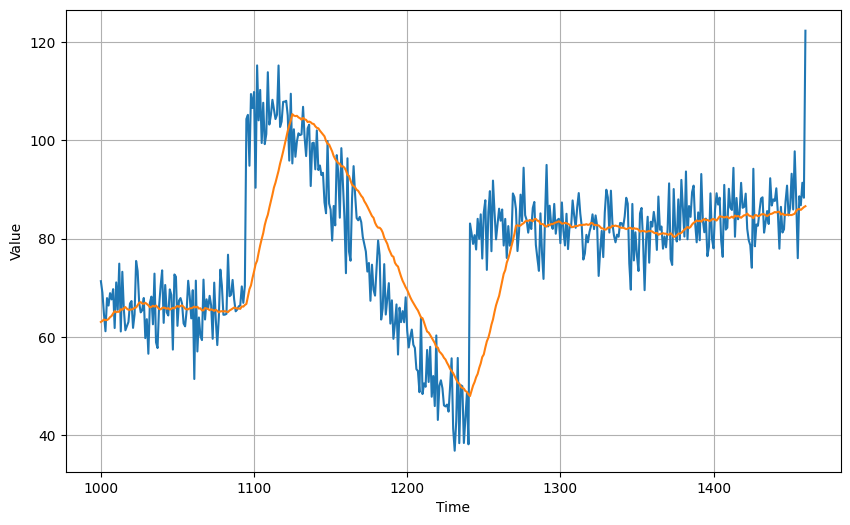

In [91]:
def moving_average_forecast(series, window_size, split_time):
    """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    moving_avg = np.array(forecast)
    moving_avg = moving_avg[split_time - window_size:]
    return moving_avg
    
window_size = 30    
moving_avg = moving_average_forecast(series, window_size=window_size, split_time=split_time)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
plt.show()

In [99]:
data_name = 'custom_data1'
model_name = 'moving_average'
df_results = update_result(df_results, data_name, model_name, x_valid, moving_avg)
df_results

,data_name,model_name,mse,mae
0,custom_data1,native_forecast,61.827499,5.9379
1,custom_data1,moving_average,106.674599,7.1424
